In [1]:
import pandas as pd
import networkx as nx
import numpy as np
%matplotlib inline
pd.options.mode.chained_assignment = None

# Get and process actual MRT network

In [2]:
stations = pd.read_csv('stations.csv')  # downloaded from https://data.gov.sg/dataset/train-station-chinese-names
stations.drop(['mrt_station_chinese', 'mrt_line_chinese'], axis=1, inplace=True)
stations.columns = ['stn_code', 'mrt_station', 'mrt_line']
stations.head()

,stn_code,mrt_station,mrt_line
0,NS1,Jurong East,North South Line
1,NS2,Bukit Batok,North South Line
2,NS3,Bukit Gombak,North South Line
3,NS4,Choa Chu Kang,North South Line
4,NS5,Yew Tee,North South Line


In [3]:
from collections import defaultdict
station2info = defaultdict(dict)
for i, row in stations.iterrows():
    if row.stn_code not in ['STC', 'PTC']:
        stn_no = int(row.stn_code[2:])
    else:
        stn_no = 0
    station2info[row.mrt_station][row.mrt_line] = stn_no

# Process mrt trips

In [4]:
trips = pd.read_csv('mrt_trips_sampled.csv', index_col='index')
# remove things like NSEW or CCL at the end
import re
regex = r"(\s[A-Z]{2}[A-Z]*)"
pattern = re.compile(regex)
def strip_line_name(x):
    matches = pattern.findall(x)
    if not matches:
        return x.strip()
    else:
        return x.replace(matches[0], '').strip()

trips.destination = trips.destination.apply(strip_line_name)
trips.origin = trips.origin.apply(strip_line_name)
trips['destination_tm'] = pd.to_datetime(trips.destination_tm, format='%H:%M:%S')
trips['origin_tm'] = pd.to_datetime(trips.origin_tm, format='%H:%M:%S')
trips = trips[trips.origin != trips.destination]
trips.head()

,destination,destination_tm,origin,origin_tm
index,,,,
0,Bugis,1900-01-01 10:04:47,Stevens,1900-01-01 09:52:23
1,Kent Ridge,1900-01-01 10:11:34,Sengkang,1900-01-01 09:27:41
2,Tai Seng,1900-01-01 09:35:59,Compassvale,1900-01-01 09:03:44
3,Labrador Park,1900-01-01 09:45:50,Bishan,1900-01-01 09:14:45
4,Joo Koon,1900-01-01 09:27:32,Boon Lay,1900-01-01 09:20:36


In [5]:
# add mrt_line information to each trip
def get_mrt_lines(x):
    lines_origin = set(station2info[x.origin].keys())
    lines_dest = set(station2info[x.destination].keys())
    intersecting = lines_origin.intersection(lines_dest)
    return ''.join(list(intersecting))

trips['mrt_lines'] = trips.apply(get_mrt_lines, axis=1)
trips.head()

,destination,destination_tm,origin,origin_tm,mrt_lines
index,,,,,
0,Bugis,1900-01-01 10:04:47,Stevens,1900-01-01 09:52:23,Downtown Line
1,Kent Ridge,1900-01-01 10:11:34,Sengkang,1900-01-01 09:27:41,
2,Tai Seng,1900-01-01 09:35:59,Compassvale,1900-01-01 09:03:44,
3,Labrador Park,1900-01-01 09:45:50,Bishan,1900-01-01 09:14:45,Circle Line
4,Joo Koon,1900-01-01 09:27:32,Boon Lay,1900-01-01 09:20:36,East West Line


# Detecting trains

First, we assume the two stations are both on the same line, or it doesn't make sense (without a stretch of definition) to talk about how many trains travelled between them. There are some corrections needed, for example some trains go from CC to CE. So first we filter by lines that the station is on. 

In [6]:
def get_direction(start_stn, end_stn):
    if end_stn > start_stn:
        return 1
    else:
        return -1

# spike detection using MAD: https://www.wikiwand.com/en/Median_absolute_deviation
def relative_madness(x):
    return abs(x[1] - np.median(x)) - np.median(abs( x - np.median(x)))

def get_num_trains(start, end, line):
    filtered = trips[trips.mrt_lines == line]
    direction = get_direction(station2info[start][line], station2info[end][line])
    filtered['origin_stn_no'] = filtered.origin.apply(lambda x: station2info[x][line])
    filtered['destination_stn_no'] = filtered.destination.apply(lambda x: station2info[x][line])
    filtered['direction'] = filtered.apply(lambda x: get_direction(x.origin_stn_no, x.destination_stn_no), axis=1)
    filtered = (filtered[filtered.direction == direction]).drop(['direction'], axis=1)
    most_freq_dest = filtered.destination.mode().values[0]
    filtered = filtered[filtered.destination == most_freq_dest]
    filtered = filtered[['origin', 'destination', 'origin_tm', 'destination_tm', 'origin_stn_no','destination_stn_no', 'mrt_lines']]
    
    # tap out is more indicative than tap in
    ts = filtered.set_index('destination_tm').groupby(pd.Grouper(freq='30s')).agg('count')
    ts = ts[['origin']]
    ts.columns = ['trips_count']
    ts.plot()
    
    # spike detection
    ts['madness'] = ts.rolling(window=3, center=True).apply(relative_madness)
    ts['spike'] = False
    ts.loc[ts.madness > 2, 'spike'] = True
    return ts.spike.sum()

# Examples

24

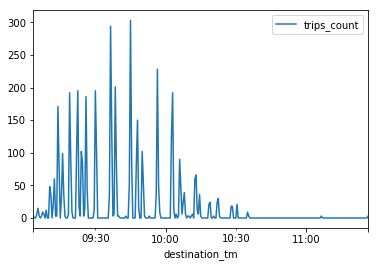

In [7]:
get_num_trains('Pioneer', 'Boon Lay', 'East West Line')

24

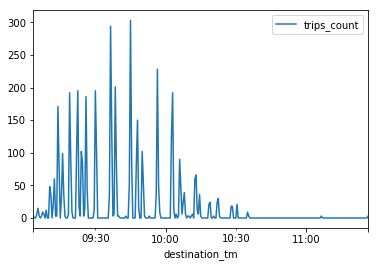

In [8]:
get_num_trains('Boon Lay', 'Pasir Ris', 'East West Line')

33

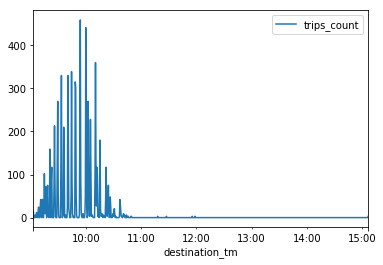

In [9]:
get_num_trains('Ang Mo Kio', 'Toa Payoh', 'North South Line')